In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Load data
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

print(f"Training data shape: {train.shape}")
print(f"Test data shape: {test.shape}")

# Look at first few rows
train.head()

Training data shape: (8693, 14)
Test data shape: (4277, 13)


,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


Missing values in training set:
PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

Target distribution:
Transported
True     0.503624
False    0.496376
Name: proportion, dtype: float64


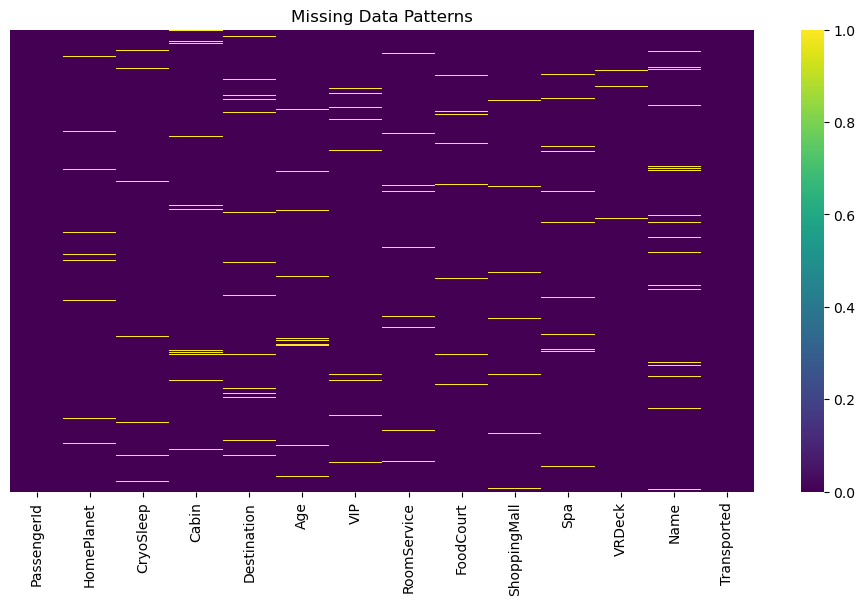

In [2]:
# Check missing values
print("Missing values in training set:")
print(train.isnull().sum())

# Check target distribution
print("\nTarget distribution:")
print(train['Transported'].value_counts(normalize=True))

# Visualize missing data patterns
plt.figure(figsize=(12, 6))
sns.heatmap(train.isnull(), cbar=True, yticklabels=False, cmap='viridis')
plt.title('Missing Data Patterns')
plt.show()

In [3]:
def engineer_features(df):
    """Create new features from existing ones"""
    
    # Extract from PassengerId
    df['Group'] = df['PassengerId'].str.split('_').str[0]
    df['GroupSize'] = df.groupby('Group')['PassengerId'].transform('count')
    df['Solo'] = (df['GroupSize'] == 1).astype(int)
    
    # Extract from Cabin
    df['Deck'] = df['Cabin'].str.split('/').str[0]
    df['CabinNumber'] = df['Cabin'].str.split('/').str[1]
    df['Side'] = df['Cabin'].str.split('/').str[2]
    
    # Extract from Name
    df['FirstName'] = df['Name'].str.split().str[0]
    df['LastName'] = df['Name'].str.split().str[1]
    df['FamilySize'] = df.groupby('LastName')['PassengerId'].transform('count')
    
    # Spending features
    spending_features = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
    df['TotalSpending'] = df[spending_features].sum(axis=1)
    df['NoSpending'] = (df['TotalSpending'] == 0).astype(int)
    
    # Age groups
    df['AgeGroup'] = pd.cut(df['Age'], bins=[0, 12, 18, 30, 50, 100], 
                            labels=['Child', 'Teen', 'Adult', 'Middle', 'Senior'])
    
    # Logical features
    df['CryoSleep'] = df['CryoSleep'].fillna(df['NoSpending'])  # If no spending, probably in cryo
    
    return df

# Apply feature engineering
train_fe = engineer_features(train.copy())
test_fe = engineer_features(test.copy())

print("New features created!")

New features created!


## Data Preprocessing

In [4]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

def preprocess_data(train_df, test_df):
    """Prepare data for modeling"""
    
    # Handle missing values
    # Numerical: fill with median
    num_features = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
    for col in num_features:
        median_value = train_df[col].median()
        train_df[col] = train_df[col].fillna(median_value)
        test_df[col] = test_df[col].fillna(median_value)
    
    # Categorical: fill with mode or 'Unknown'
    cat_features = ['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'Deck', 'Side']
    for col in cat_features:
        mode_value = train_df[col].mode()[0] if not train_df[col].mode().empty else 'Unknown'
        train_df[col] = train_df[col].fillna(mode_value)
        test_df[col] = test_df[col].fillna(mode_value)
    
    # Encode categorical variables
    le_dict = {}
    for col in cat_features + ['AgeGroup']:
        le = LabelEncoder()
        # Fit on combined data to ensure consistent encoding
        combined = pd.concat([train_df[col], test_df[col]])
        le.fit(combined.astype(str))
        train_df[col] = le.transform(train_df[col].astype(str))
        test_df[col] = le.transform(test_df[col].astype(str))
        le_dict[col] = le
    
    # Select features for modeling
    feature_cols = ['HomePlanet', 'CryoSleep', 'Destination', 'Age', 'VIP',
                   'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
                   'GroupSize', 'Solo', 'Deck', 'Side', 'FamilySize',
                   'TotalSpending', 'NoSpending', 'AgeGroup']
    
    # Prepare final datasets
    X_train = train_df[feature_cols]
    y_train = train_df['Transported']
    X_test = test_df[feature_cols]
    
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    return X_train_scaled, X_test_scaled, y_train

# Preprocess
X_train, X_test_final, y_train = preprocess_data(train_fe, test_fe)

print(f"Training features: {X_train.shape}")
print(f"Test features: {X_test_final.shape}")

Training features: (8693, 18)
Test features: (4277, 18)
